<a href="https://colab.research.google.com/github/DavidMartinezGonzalez/TutorialOnNeuralVocoders/blob/main/chapter_3_DSP_in_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome


This is the hands-on session for ICASSP 2022 short course **Inclusive Neural Speech Synthesis**, **LECTURE 1, neural vocoder**.

Click [HERE](https://colab.research.google.com/drive/1EO-ggi1U9f2zXwTiqg7AEljVx11JKta7?usp=sharing) to go back to the entry point of this hands-on session.


## About this notebook

In this notebook, we cover
1. linear time-invariant filtering as 1D convolution
2. similar but convolution between two signals
3. linear time-variant filtering
4. sinc-windowed filter for linear time-variant filtering

They are implemented as Pytorch Module and can be plugged into the neural vocoders. The last point on sinc-windowed filter is related to [SincNet](https://arxiv.org/abs/1808.00158), [CREPE](https://arxiv.org/abs/1802.06182), and many other recent DNN-based speech processing tools.


For each section, we will
1. Define the Module
2. Show an example of usage


## Preparation

This hands-on session is based on Python (Numpy & Scipy) and Pytorch, and dependency should have been provided by the Colab runtime.

We only need to download some pre-trained models and example data:
(FYI: when the virtual runtime machine on Colab is released and reallocated, we need to download the file again)

In [ ]:
!echo "Download external zip "
!wget --quiet --show-progress -O iNSS.zip https://www.dropbox.com/sh/bua2vks8clnl2ha/AABxjrZhQBRM1YEekjWs8Pl2a/iNSS
!echo "Unzip files"
!unzip -q -o iNSS.zip -x / -d /content
!if [ -d "/content/data_models" ]; then echo "Done"; else echo "Please contact with the author"; fi

Download external zip 
iNSS.zip            100%[===================>] 420.85M   109MB/s    in 5.2s    
Unzip files
Done


In [ ]:
# for convenience, define a path to the folder on Google Colab runtime
g_workpath = '/content'

# Sec.1 Linear Time-Invariant Filtering

## Sec.1.1 Explanation

Given an input signal $\boldsymbol{x}_{1:N}=\{x_{1}, x_{2}, \cdots, x_N\}$ and a finite impulse response filter $H(z)=h_0 + h_1 z^{-1} + h_{K-1} z^{-(k-1)}$, an output signal $\boldsymbol{y}_{1:N}$ can be computed as

$y_n = \sum_{k=0}^{K-1} h_{k}x_{n-k}$
$= h_{0}x_{n} + h_{1}x_{n-1} + \cdots + h_{K-1}x_{n-({K-1})}$

The above equation is similar to 1D convolution with one input channel and one output channel.

Furthermore, the time-invariant filtering process is differentiable.

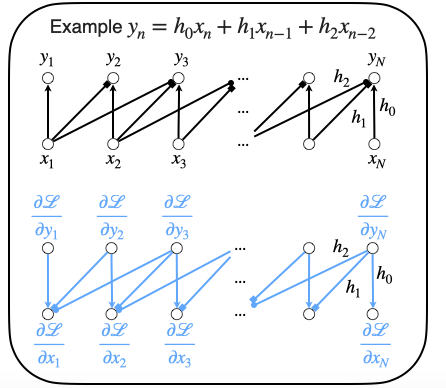

In [ ]:
from IPython.display import Image
Image(filename="/content/figures/fig_c5_1.png")

We will define a Pytorch Module for this operator.

## Sec.1.2 Pytorch Module Definition


This module expects:
1. Input tensor has shape `(batchsize, length, dim)`
2. Input filter coefficients are in shape `(filter_order)`
3. Output tensor has shape `(batchsize, length, dim)`

Suppose the input tensor is in shape (batchsize=B, length, dim=N). The wrapper interprets the input tensor as $BN$ 1-d signals of size (1, length, 1).

It filters each of the $BN$ 1-d signals independently, using the same filter coefficients.

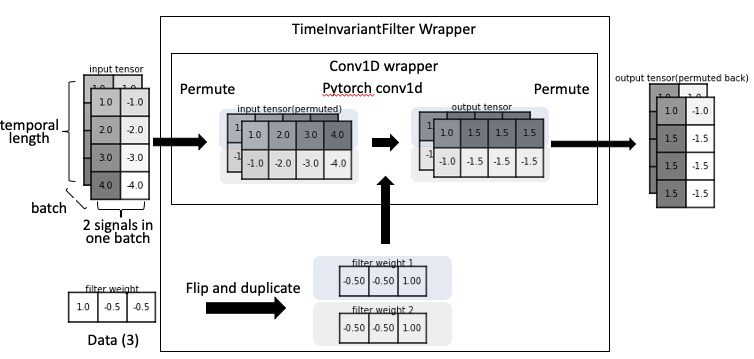

In [ ]:
from IPython.display import Image
Image(filename="/content/figures/fig_c5_2.png")

The Module is wrapped over the Conv1D (`Conv1DKeepLength`) introduced in chapter_1.

In [ ]:
# This is the Conv1DKeepLength module introduced in chapter_1.
#

import torch
import torch.nn as torch_nn
import torch.nn.functional as torch_nn_func

class Conv1dKeepLength(torch_nn.Conv1d):
    """ Wrapper for causal convolution
    Input tensor:  (batchsize, length, dim_in)
    Output tensor: (batchsize, length, dim_out)

    """
    def __init__(self, input_dim, output_dim, dilation_s, kernel_s,
                 causal = False, stride = 1, groups=1, bias=True, \
                 tanh = True, pad_mode='constant'):
        super(Conv1dKeepLength, self).__init__(
            input_dim, output_dim, kernel_s, stride=1,
            padding = 0, dilation = dilation_s, groups=groups, bias=bias)

        self.pad_mode = pad_mode
        self.causal = causal

        # padding size
        # input & output length will be the same
        if self.causal:
            # left pad to make the convolution causal
            self.pad_le = dilation_s * (kernel_s - 1)
            self.pad_ri = 0
        else:
            # pad on both sizes
            self.pad_le = dilation_s * (kernel_s - 1) // 2
            self.pad_ri = dilation_s * (kernel_s - 1) - self.pad_le

        # activation functions
        if tanh:
            self.l_ac = torch_nn.Tanh()
        else:
            self.l_ac = torch_nn.Identity()

    def forward(self, data):
        # https://github.com/pytorch/pytorch/issues/1333
        # permute to (batchsize=1, dim, length)
        # add one dimension as (batchsize=1, dim, ADDED_DIM, length)
        # pad to ADDED_DIM
        # squeeze and return to (batchsize=1, dim, length+pad_length)
        x = torch_nn_func.pad(data.permute(0, 2, 1).unsqueeze(2), \
                              (self.pad_le, self.pad_ri,0,0), \
                              mode = self.pad_mode).squeeze(2)
        # tanh(conv1())
        # permmute back to (batchsize=1, length, dim)
        output = self.l_ac(super(Conv1dKeepLength, self).forward(x))
        return output.permute(0, 2, 1)

In [ ]:

class TimeInvFIRFilter(Conv1dKeepLength):
    """ Wrapper to define a FIR filter
        input tensor  (batchsize, length, feature_dim)
        output tensor (batchsize, length, feature_dim)

        Define:
            TimeInvFIRFilter(feature_dim, filter_coef,
                             causal=True, flag_trainable=False)
        feature_dim: dimension of the feature in each time step
        filter_coef: a 1-D torch.tensor of the filter coefficients
        causal: causal filtering y_i = sum_k=0^K a_k x_i-k
                non-causal: y_i = sum_k=0^K a_k x_i+K/2-k
        flag_trainable: whether update filter coefficients (default False)
    """
    def __init__(self, feature_dim, filter_coef, causal=True,
                 flag_trainable=False):
        # define based on Conv1d with stride=1, tanh=False, bias=False
        # groups = feature_dim make sure that each signal is filtered separated
        super(TimeInvFIRFilter, self).__init__(
            feature_dim, feature_dim, 1, filter_coef.shape[0], causal,
            groups=feature_dim, bias=False, tanh=False)

        if filter_coef.ndim == 1:
            # initialize weight and load filter coefficients
            with torch.no_grad():
                tmp_coef = torch.zeros([feature_dim, 1, filter_coef.shape[0]])
                tmp_coef[:, 0, :] = filter_coef
                tmp_coef = torch.flip(tmp_coef, dims=[2])
                self.weight = torch.nn.Parameter(tmp_coef, requires_grad = flag_trainable)
        else:
            print("TimeInvFIRFilter expects filter_coef to be 1-D tensor")
            print("Please implement the code in __init__ if necessary")
            sys.exit(1)

    def forward(self, data):
        return super(TimeInvFIRFilter, self).forward(data)

A few notes:

1. *TimeInvFirFilter* is a 1D convolution layer with *groups=feature_dim*. This is equivalent to using `groups=in_channels: each input channel is convolved with its own set of filters`, according to [Pytorch doc](https://pytorch.org/docs/master/generated/torch.nn.Conv1d.html).

2. The layer weight is initialized by duplicating the filter coefficients for each feature dimension (or input/output channel):
```
tmp_coef = torch.zeros([feature_dim, 1, filter_coef.shape[0]])
tmp_coef[:, 0, :] = filter_coef
```

3. The layer weights need to be flipped. As being plotted in the 1st figure above, the CNN kernel is formulated as [h2, h1, h0]:
```
tmp_coef = torch.flip(tmp_coef, dims=[2])
```



## Sec.1.3 Example Usage

Consider a simple filter with coefficients $\{h_0 = 1, h_1 = -0.5, h_2 = -0.5\}$

(<Figure size 108x36 with 1 Axes>,
 [<matplotlib.axes._axes.Axes at 0x7f6df4726250>])

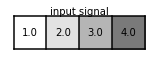

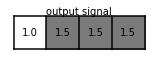

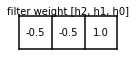

In [ ]:
# input signal
input_signal = torch.arange(1.0, 5.0, 1).unsqueeze(0).unsqueeze(2)

# filter coefficients
coef = [1, -0.5, -0.5]

# Initialzie the layer
filter_layer = TimeInvFIRFilter(input_signal.shape[-1], torch.tensor(coef))

# Do filtering using TimeInvFIRFilter
with torch.no_grad():
    # get output signal
    signal_output = filter_layer(input_signal)

import plot_lib
plot_lib.plot_tensor(
    input_signal.permute(0, 2, 1), color_on_value=True, title="input signal")
plot_lib.plot_tensor(
    signal_output.permute(0, 2, 1), color_on_value=True, title="output signal")
plot_lib.plot_tensor(
    filter_layer.weight, color_on_value=False,
    colorgrad_x=False, colorgrad_y=False, title="filter weight [h2, h1, h0]")

Please verify the results:
```sh
signal_output[0] <- input_signal[0] * h0
signal_output[1] <- input_signal[1] * h0 + input_signal[0] * h1
signal_output[2] <- input_signal[2] * h0 + input_signal[1] * h1+  input_signal[0] * h2
...
```

Below are examples using batched input

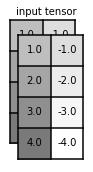

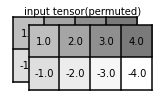

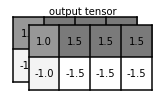

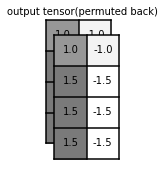

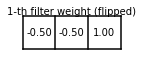

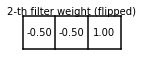

In [ ]:
# input signal
signal_input = torch.arange(1.0, 5.0, 1).unsqueeze(0).unsqueeze(2)
signal_input = signal_input.repeat(2, 1, 2)
signal_input[:, :, 1] = torch.arange(-1.0, -5.0, -1)

# filter coefficients
coef = [1, -0.5, -0.5]

# initialize layer
filter_layer = TimeInvFIRFilter(signal_input.shape[-1], torch.tensor(coef))

# Do filtering using TimeInvFIRFilter
with torch.no_grad():
    # get output signal
    signal_output = filter_layer(signal_input)


import plot_lib
plot_lib.plot_tensor(signal_input, color_on_value=True, title="input tensor")
plot_lib.plot_tensor(signal_input.permute(0, 2, 1),
                     color_on_value=True, title="input tensor(permuted)")
plot_lib.plot_tensor(signal_output.permute(0, 2, 1),
                     color_on_value=True, title="output tensor")
plot_lib.plot_tensor(signal_output, color_on_value=True,
                     title="output tensor(permuted back)")

for feat_map_idx in range(filter_layer.weight.shape[0]):
    plot_lib.plot_tensor(filter_layer.weight[feat_map_idx:feat_map_idx+1], color_on_value=False,
                         colorgrad_x=False, colorgrad_y=False, colormap='Greys', alpha=1.0,
                         title = '{:d}-th filter weight (flipped)'.format(feat_map_idx + 1),
                         deci_width=2)

## Sec.1.4 Use it for filtering

In this example, we define high-pass and low-pass filters and process some random signals.  

For sanity check, we also use the scipy.signal package to do the filtering, and we can compare the results.

In [ ]:
from scipy import signal as sci_signal
import scipy.fft
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (10, 5)

# Prepare filters coefficients
# these are the filters used in my own project
lp_v = [0.08538414199291068, 0.04920229475534168, -0.1470178606967731, 0.24737764593887432, 0.7103067853166558, 0.24737764593887432, -0.1470178606967731, 0.04920229475534168, 0.08538414199291068]
lp_u = [0.00936455546502, 0.0416254862901, 0.0878313219556, 0.146086321198, 0.192602581136, 0.211221591449, 0.192602581136, 0.146086321198, 0.0878313219556, 0.0416254862901, 0.00936455546502]
hp_v = [-0.00936455546502148, 0.04162548629009957, -0.08783132195564508, 0.1460863211980122, -0.19260258113649556,  0.21122159144894015, -0.19260258113649556, 0.1460863211980122, -0.08783132195564508, 0.04162548629009957, -0.00936455546502148]
hp_u = [0.0853841419929, -0.0492022947553, -0.147017860697, -0.247377645939, 0.710306785317, -0.247377645939, -0.147017860697, -0.0492022947553, 0.0853841419929]

# let's try a loss-pass filter
coef = lp_u


In [ ]:
# Use the Pytorch Module
# configurations
signal_dim = 1
signal_length = 1000
batch_size = 2
# input signal
signal_input = torch.randn(batch_size, signal_length, signal_dim)
signal_input = signal_input/signal_input.sum(axis=1, keepdim=True)


# Create a FIR filter layer
filter_layer = TimeInvFIRFilter(signal_dim, torch.tensor(coef))

with torch.no_grad():

    # get output signal
    # input should be a tensor in shape (batch, length, dim)
    # output will be a tensor in shape (batch, length, dim)
    signal_output = filter_layer(signal_input)


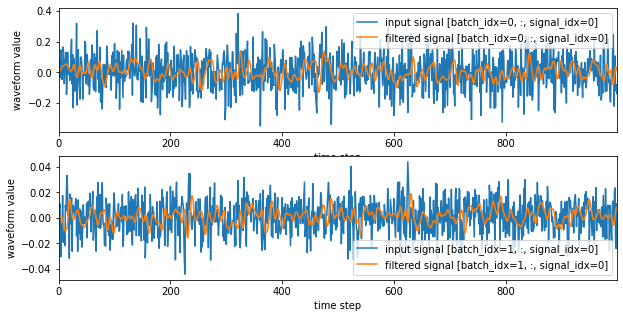

In [ ]:
# plot the input and output signals
batchsize = signal_input.shape[0]
signal_num = signal_input.shape[2]

fig = plt.figure()
for batch_idx in range(batchsize):
    for signal_idx in range(signal_num):
        axis = fig.add_subplot(batchsize, signal_num, batch_idx * signal_num + signal_idx+1)

        plot_lib.plot_signal(signal_input[batch_idx, :, signal_idx].numpy(),
                             fig, axis, xlabel='time step', ylabel='waveform value')
        plot_lib.plot_signal(signal_output[batch_idx, :, signal_idx].numpy(),
                             fig, axis, xlabel='time step', ylabel='waveform value')
        plt.legend(['input signal [batch_idx={:d}, :, signal_idx={:d}]'.format(batch_idx, signal_idx),
                    'filtered signal [batch_idx={:d}, :, signal_idx={:d}]'.format(batch_idx, signal_idx)])
        #axis.set_title('batch %d, signal %d' % (batch_idx, signal_idx))


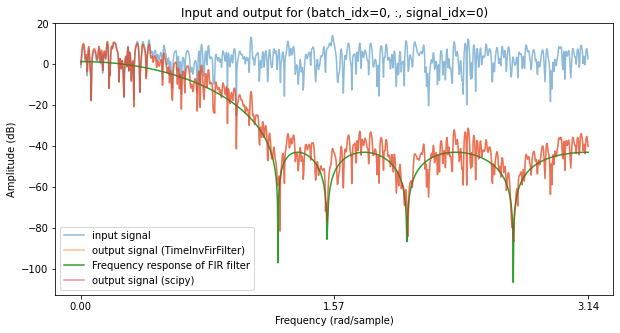

In [ ]:
# Compare with scipy API

# We only plot one signal
batch_idx = 0
signal_idx = 0

# fft points for figure plotting (nfft should be > signal_length)
nfft = 2048

# get the input and output signals from the tensor
signal_input_single = signal_input.numpy()[batch_idx, :, signal_idx]
signal_output_single = signal_output.numpy()[batch_idx, :, signal_idx]

# Do filtering using scipy, for sanity check
scipy_output_scipy = scipy.signal.lfilter(coef, [1], signal_input_single)

# plot the spectral
def plot_spectral(signal_tmp, fig, axis):
    h = scipy.fft.fft(signal_tmp * np.hanning(signal_tmp.shape[0]), n=nfft)
    axis.plot(20*np.log10(np.abs(h[0:nfft//2+1]) + np.finfo(np.float32).eps), alpha=0.5)
    axis.set_title('Input and output for (batch_idx=%d, :, signal_idx=%d)' % (batch_idx, signal_idx))
    axis.set_xlabel('Frequency (rad/sample)')
    axis.set_ylabel('Amplitude (dB)')
    axis.set_xticks([0, nfft // 4, nfft // 2])
    axis.set_xticklabels(['%1.2f' % (x * 2 * np.pi) for x in [0, 0.25, 0.5]])

def plot_freq_response(filter_coef, fig, axis):
    w, h = scipy.signal.freqz(filter_coef, [1], worN=nfft, whole=True)
    axis.plot(20*np.log10(np.abs(h[0:nfft//2+1]) + np.finfo(np.float32).eps))

fig = plt.figure()
axis = fig.add_subplot(111)
plot_spectral(signal_input_single, fig, axis)
plot_spectral(signal_output_single, fig, axis)
plot_freq_response(coef, fig, axis)
plot_spectral(scipy_output_scipy, fig, axis)
plt.legend(['input signal', 'output signal (TimeInvFirFilter)',
            'Frequency response of FIR filter', 'output signal (scipy)'])


## Sec.1.5 A Specific Filtering: Moving Average

It is also straightforward to define a moving-average-based signal smoothing function based on `Conv1dKeepLength`

While it is possible to define it using `TimeInvFilter`, I directly define it through `Conv1dKeepLength`

In [ ]:
class MovingAverage(Conv1dKeepLength):
    """ Wrapper to define a moving average smoothing layer based on Conv1dKeepLength
    input tensor  (batchsize, length, feature_dim)
    output tensor (batchsize, length, feature_dim)
    Moving averaging is conducted separately for each feature_dimension and each sequence

    Define:
        MovingAverage(feature_dim, window_len, causal=False)

        feature_dim:
        window_len: the length of the moving average window
        causal: when False, the window is centered on the current point
                when True, it is y_i = 1/K * sum_k=0^K x_i-k
    """
    def __init__(self, feature_dim, window_len, causal=False):
        super(MovingAverage, self).__init__(
            feature_dim, feature_dim, 1, window_len, causal,
            groups=feature_dim, bias=False, tanh=False)
        # same
        torch_nn.init.constant_(self.weight, 1/window_len)
        for p in self.parameters():
            p.requires_grad = False

    def forward(self, data):
        return super(MovingAverage, self).forward(data)

(<Figure size 108x36 with 1 Axes>,
 [<matplotlib.axes._axes.Axes at 0x7f09bbc60490>])

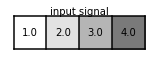

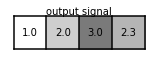

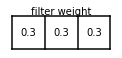

In [ ]:
# input signal
signal_input = torch.arange(1.0, 5.0, 1).unsqueeze(0).unsqueeze(2)

# length of the moving average filter (window)
window_size = 3

# Do filtering ()
filter_layer = MovingAverage(signal_input.shape[2], window_size, causal = False)

with torch.no_grad():
    # get output signal
    signal_output = filter_layer(signal_input)

import plot_lib
plot_lib.plot_tensor(signal_input.permute(0, 2, 1),
                     color_on_value=True, title="input signal")
plot_lib.plot_tensor(signal_output.permute(0, 2, 1),
                     color_on_value=True, title="output signal")
plot_lib.plot_tensor(filter_layer.weight,
                     color_on_value=False, colorgrad_x=False,
                     colorgrad_y=False, title="filter weight")

## Sec.1.6 Notes

The above example assumes that the filter coefficients are fixed and non-trainable.

The module above also supports trainable filter coefficients by setting `flag_trainable=True`.

Such a trainable time-invariant filter may also be used for applications where the filter coefficients can be used to initialize the network and further fine-tuned on the data through back-propagation.

# Sec.2 Convolution between Two Signals




## Sec.2.1 Explanation

Time-invariant filter in Sec.1 assumes that the filter coefficients are stored as the weight of the 1D convolution layer.

However, when we wish to predict the filter coefficients using another network, we need to use a different API that receives the filter coefficients as input rather than Module.parameter.  

This is the motivation. The filter coefficient sequence is simply treated as a signal (i.e., impulse response).

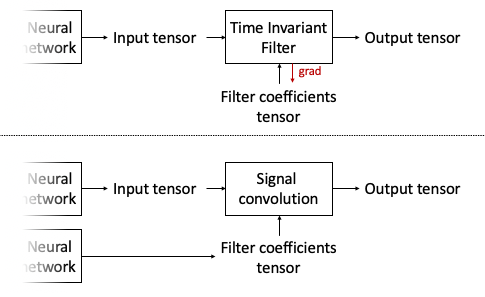

In [ ]:
from IPython.display import Image
Image(filename="/content/figures/fig_c6_1.png")

## Sec.2.2 Pytorch Module Definition

We define a wrapper over `torch.nn.functional.conv1d`:
1. Input 1 is a tensor of shape `(batchsize, length, dim)`
2. Input 2 is a tensor of shape `(length_2, dim)`, which is assumed as the time-invarint filter coefficients
3. Output tensor has shape `(batchsize, length, dim)`
4. Convolution is conducted for each dimension separately.

I apologize that the tensor of Input 2 is in shape `(length_2, dim)` rather than `(batchsize=1, length_2, dim)`.

Figure beblow illustrates the process.

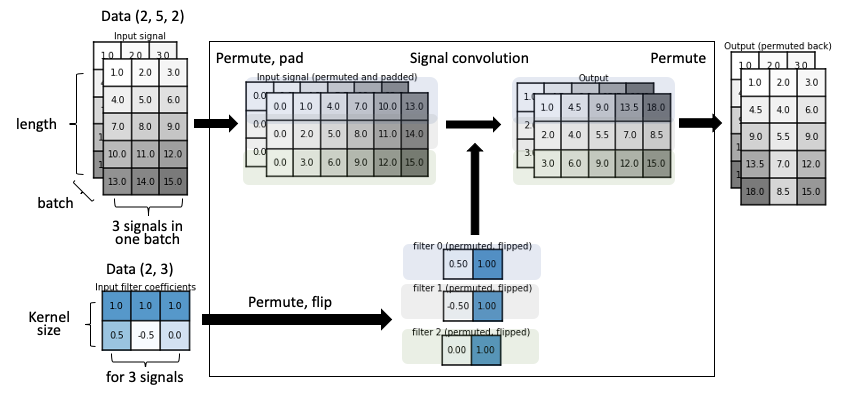

In [ ]:
Image(filename="/content/figures/fig_c6_2.png")

In [ ]:
import sys
import torch
import torch.nn as torch_nn
import torch.nn.functional as torch_nn_func


class SignalsConv1d(torch_nn.Module):
    """ Filtering input signal with time invariant filter

    Define:
        SignalsConv1d()
    See usage in forward() method
    """
    def __init__(self):
        super(SignalsConv1d, self).__init__()

    def forward(self, signal, system_ir):
        """ output = forward(signal, system_ir)

        signal:    (batchsize, length1, dim)
        system_ir: (length2, dim)

        output:    (batchsize, length1, dim)

        Note:
        """
        if signal.shape[-1] != system_ir.shape[-1]:
            print("Error: TimeInvariantFiltering expects shape:")
            print("signal    (batchsize, length1, dim)")
            print("system_id (batchsize, length2, dim)")
            sys.exit(1)

        # similar opration to Conv1dInvFilter
        # system_ir.shape[0] -> kernel_size
        # padding length
        padding_length = system_ir.shape[0] - 1

        # groups = signal.shape[-1] so that convoluion is separately
        #  for each dimension
        groups = signal.shape[-1]

        # 1. switch dimension of the signal from (batch, length, dim) to (batch, dim, length)
        # 2. pad signal on the left to (batch, dim, length + pad_length)
        signal_pad = torch_nn_func.pad(signal.permute(0, 2, 1),\
                                       (padding_length, 0))

        # 1. add one dimension to system_ir and makes its shape (length2, 1, dim)
        # 2. switch dimension and prepare system_id as (dim, 1, length2)
        # 3. flip the impulse response
        ir = torch.flip(system_ir.unsqueeze(1).permute(2, 1, 0), \
                        dims=[2])

        # convolute
        output = torch_nn_func.conv1d(signal_pad, ir, \
                                      groups=groups)
        # switch dimension from (batch, dim, length) to (batch, length, dim)
        return output.permute(0, 2, 1)

## Sec.2.3 Example Usage

In [ ]:
from scipy import signal as sci_signal
import scipy.fft
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (10, 5)

# define input signal
data = torch.zeros([1, 5, 3])
data[0] = torch.tensor([[1,2,3], [4,5,6], [7,8,9], [10,11,12],[13,14,15]])
signal_input = data

# define 3 filters of order 2
filter_coefs_ir = torch.ones(2, 3)
filter_coefs_ir[1:, 0] = 0.5
filter_coefs_ir[1:, 1] = -0.5
filter_coefs_ir[1:, 2] = 0
# filter order (or kernel size)
filter_kernel_size = filter_coefs_ir.shape[0]

assert filter_coefs_ir.shape[1] == signal_input.shape[-1]

print("Input tensor have shape", str(signal_input.shape))
print("Filter coefs have shape", str(filter_coefs_ir.shape))

Input tensor have shape torch.Size([1, 5, 3])
Filter coefs have shape torch.Size([2, 3])


In [ ]:
# create the Module
l_signal_convolution = SignalsConv1d()

# do filtering
signal_output = l_signal_convolution(signal_input, filter_coefs_ir)

print("Output tensor have shape", str(signal_output.shape))

Output tensor have shape torch.Size([1, 5, 3])


(<Figure size 72x36 with 1 Axes>,
 [<matplotlib.axes._axes.Axes at 0x7feae7734b50>])

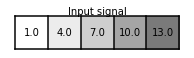

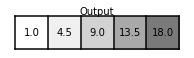

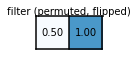

In [ ]:
# plot one dimension

dim_index = 0

import plot_lib
plot_lib.plot_tensor(signal_input[:, :, dim_index:dim_index+1].permute(0, 2, 1),
                     color_on_value=True, title='Input signal')
plot_lib.plot_tensor(signal_output[:, :,dim_index:dim_index+1].permute(0, 2, 1),
                     color_on_value=True, title='Output')

# step2. flip and store the input filter coefficients
filter_coefs_ir_flipped = torch.flip(filter_coefs_ir.unsqueeze(1).permute(2, 1, 0), dims=[2])

plot_lib.plot_tensor(filter_coefs_ir_flipped[dim_index:dim_index+1],
                     color_on_value=True, colormap="Blues", alpha=1.0,
                     title = 'filter (permuted, flipped)', deci_width=2)


## Sec.2.4 Example on Pre-emphasis

Here we can try to define the pre-emphasis filter $H(z)=1 - 0.97z^{-1}$.


In [ ]:
# input signal
signal_input = torch.randn(1, 100, 1)

# impulse response of an identiy sytem [1, -0.97] -> A high-pass filter
system_ir = torch.ones(2, 1)
system_ir[1:, :] = -0.97

# do filtering
filter_layer = SignalsConv1d()
signal_output = filter_layer(signal_input, system_ir)

[Text(0, 0, '0.00'), Text(0, 0, '1.57'), Text(0, 0, '3.14')]

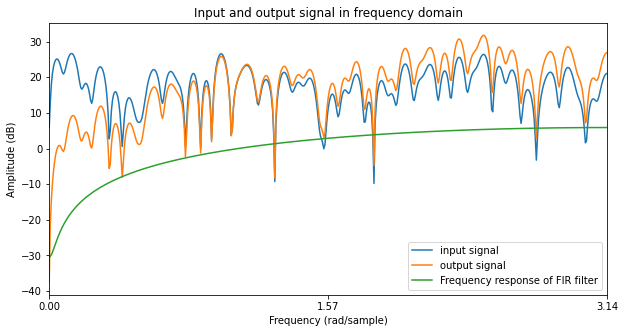

In [ ]:
import plot_lib

# plot in frequency domain
nfft = 1024
fig = plt.figure()
axis = fig.add_subplot(111)

# signal spectrum
h = scipy.fft.fft(signal_input[0, :, 0].detach().numpy(), n=nfft)
h = 20*np.log10(np.abs(h[0:nfft//2+1]) + np.finfo(np.float32).eps)
plot_lib.plot_signal(h, fig, axis)

h = scipy.fft.fft(signal_output[0, :, 0].detach().numpy(), n=nfft)
h = 20*np.log10(np.abs(h[0:nfft//2+1]) + np.finfo(np.float32).eps)
plot_lib.plot_signal(h, fig, axis)

# filter frequency response
w, h = scipy.signal.freqz(system_ir[:, 0], [1], worN=nfft, whole=True)
h = 20*np.log10(np.abs(h[0:nfft//2+1]) + np.finfo(np.float32).eps)
plot_lib.plot_signal(h, fig, axis, title='Input and output signal in frequency domain',
                    xlabel='Frequency (rad/sample)', ylabel='Amplitude (dB)')

axis.legend(['input signal', 'output signal', 'Frequency response of FIR filter'])
axis.set_xticks([0, nfft // 4, nfft // 2])
axis.set_xticklabels(['%1.2f' % (x * 2 * np.pi) for x in [0, 0.25, 0.5]])

# Sec.3 Linear Time-Variant Filtering



## Sec.3.1 Explanation


Linear time-variant filter assumes that the filter coefficients are changing across time.

Consider one filter is available for each time step $n\in\{0, \cdots, N-1\}$. We define them as a sequence of filters $\{\{h_{0,1}, h_{1,1}, h_{K-1,1}\}, \{h_{0,2}, h_{1,2}, h_{K-1,2}\}, \cdots, \{h_{0,N-1}, h_{1,N-1}, h_{K-1,N-1}\}\}$.

Given an input sequence $x_{0:N-1}=\{x_0, \cdots, x_{N-1}\}$, the output $y_n$ at the $n$-th time step can be computed as

$y_n = \sum_{k=0}^{K-1} h_{k,\color{red}{n}}x_{n-k}= h_{0,\color{red}{n}}x_{n} + h_{1,\color{red}{n}}x_{n-1} + \cdots + h_{K-1,\color{red}{n}}x_{n-({K-1})}$


Figure below shows an example.

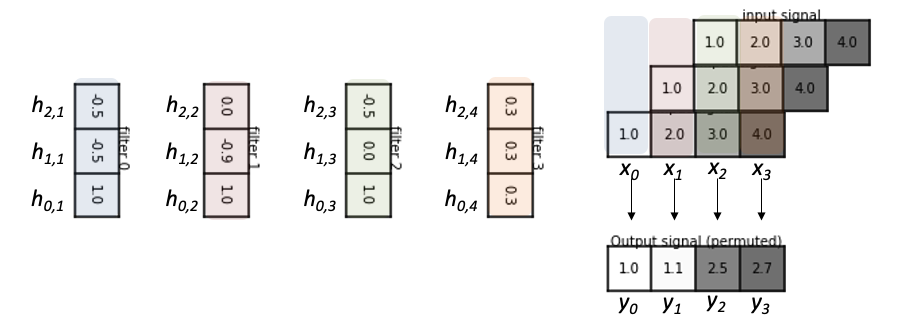

In [ ]:
Image("./figures/fig_c7_1.png")

## Sec.3.2 Pytorch Module Definition


We assume
1. Input tensor has shape `(batchsize, length, dim)`
2. Input filter coefficients is in shape `(batchsize, length, filter_order)`
3. Output tensor has shape `(batchsize, length, dim)`

The above conventions are different from the time-invariant filtering API. Note that the filter coefficients tensor has a leading dimension that corresponds to batch size.  

Suppose the input tensor is in shape `(batchsize=B, length, dim=N)` and the filter tensor is in shape `(B, length, order=K)`,  the Module conducts filtering for each batch independently.

* Input[0] is filtered using filter[0]
* Input[1] is filtered using filter[1]
...

Then, the $N$ dimensions in Input[b] are treated as $N$ 1-D signals, and they are processed by the same filter[b].

In [ ]:
import torch
import torch.nn as torch_nn
import torch.nn.functional as torch_nn_func
import sys

class TimeVariantFiltering(torch_nn.Module):
    """ TimeVariantFiltering
    Given sequences of filter coefficients and a signal, do filtering

    Initialization: TimeVariantFiltering()
    Forward: output = forward(self, signal, filter_coef)

        Filter_coefs: (batchsize, signal_length, filter_order = K)

                      (n, m, :) is the filter coefficients for the m-th
                      time step for n-th tensor in the batch

        Signal:       (batchsize, signal_length, dim)

        Output:       (batchsize, signal_length, dim)


    Filtering is conducted for d \in [0, dim), assuming they use the same
    time-variant filter.

    For time invariant case, given signal [x_1, ..., x_N], filter [a_1, ..., a_K]
    we get output
                    [y_1, y_2, y_3, ..., y_N, *, * ... *]
            = a_1 * [x_1, x_2, x_3, ..., x_N,   0, ...,   0]
            + a_2 * [  0, x_1, x_2, x_3, ..., x_N,   0, ...,  0]
            + a_3 * [  0,   0, x_1, x_2, x_3, ..., x_N, 0, ...,  0]
            + ...

    For time variant casse, given signal [x_1, ..., x_N], filter matrix
    [[a_{1,1}, ..., a_{K,1}], [a_{1,2}, ..., a_{K,2}], ...], we get output

                    y_1,                 y_2,              y_3,
            = a_{1,1} * x_1  = a_{1,2} * x_2   = a_{1,3} * x_3
            + a_{2,1} *   0  + a_{2,2} * x_1   + a_{2,3} * x_2
            + a_{3,1} *   0  + a_{3,2} *   0   + a_{3,3} * x_1
            + ...            + ...             + ...

    """
    def __init__(self):
        super(TimeVariantFiltering, self).__init__()

    def forward(self, signal, f_coef):
        """
        input
        -----
          f_coef: (batchsize, signal_length, filter_order = K)
                      (n, m, :) is the filter coefficients for the m-th
                      time step for n-th tensor in the batch
          signal: (batchsize, signal_length, dim)

        Output
        ------
          output: (batchsize, signal_length, dim)
        """
        # signal length
        signal_l = signal.shape[1]
        # order of the time varint filter
        order_k = f_coef.shape[-1]

        # pad to signal (batchsize, signal_length + filter_order-1, dim)
        padded_signal = torch_nn_func.pad(signal, (0, 0, 0, order_k - 1))

        output = torch.zeros_like(signal)
        # roll and weighted sum, only take [0:signal_length]
        for k in range(order_k):
            output += torch.roll(padded_signal, k, dims=1)[:, 0:signal_l, :] \
                      * f_coef[:, :, k:k+1]
        return output


## Sec.3.3 Example Usage

In [ ]:
# input signal
# make it a batch (batchsize=1, length=4, dim=1)
data = torch.arange(1.0, 5.0, 1).unsqueeze(0).unsqueeze(2)

# filter coefficients
# make it a batch (batchsize=1, length=4, order=3)
coef = [[1, -0.5, -0.5], [1, -0.9, 0], [1, 0, -0.5], [0.3, 0.3, 0.3]]
coef = torch.tensor(coef).unsqueeze(0)

# signal length
signal_l = data.shape[1]
# order of the time varint filter
order_k = coef.shape[-1]

# do filter
l_tv_filter = TimeVariantFiltering()
output = l_tv_filter(data, coef)


(<Figure size 144x36 with 1 Axes>,
 [<matplotlib.axes._axes.Axes at 0x7f93e9b0a450>])

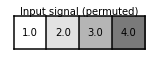

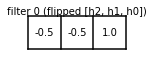

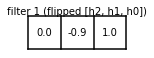

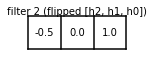

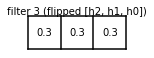

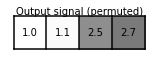

In [ ]:
import plot_lib
plot_lib.plot_tensor(data.permute(0, 2, 1), color_on_value=True, title="Input signal (permuted)")

# for plotting we flip the filter coefficients
for time_idx in range(coef.shape[1]):
    plot_lib.plot_tensor(torch.flip(coef[:, time_idx:time_idx+1, ], dims=[2]),
                         color_on_value=False, colorgrad_x=False, colorgrad_y=False,
                         colormap="Greys", alpha=1.0, title = 'filter {:d} (flipped [h2, h1, h0])'.format(time_idx))

plot_lib.plot_tensor(output.permute(0, 2, 1), color_on_value=True, title="Output signal (permuted)")

```sh
output[0] = input[0] * filter0_h0
output[1] = input[1] * filter1_h0 + input[0] * filter1_h1
output[2] = input[2] * filter2_h0 + input[1] * filter2_h1 + input[0] * filter2_h2
```

## Sec.3.4 A More Complicated Example

This is an example of using time-variant filtering to process random signals.

First, we create a tensor to store the time-variant filter coefficients. Notice that we use different filter coefficients *lp_v*, *hp_v*, and *hp_u*.


In [ ]:
from scipy import signal as sci_signal
import scipy.fft
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (10, 5)


# Prepare input signal
signal_length = 1000
signal_dim = 2
batch_size = 2

signal_input = torch.randn(batch_size, signal_length, signal_dim, requires_grad = False)


# Prepare a time-variant filter based on the following filter coefficients
# The filter coefficients should be in shape [batch_size, signal_length, filter_order]
# In this example, different batches use the same filter coefs
lp_v = torch.tensor([0.08538414199291068, 0.04920229475534168, -0.1470178606967731, 0.24737764593887432, 0.7103067853166558, 0.24737764593887432, -0.1470178606967731, 0.04920229475534168, 0.08538414199291068])
lp_u = torch.tensor([0.00936455546502, 0.0416254862901, 0.0878313219556, 0.146086321198, 0.192602581136, 0.211221591449, 0.192602581136, 0.146086321198, 0.0878313219556, 0.0416254862901, 0.00936455546502])
hp_v = torch.tensor([-0.00936455546502148, 0.04162548629009957, -0.08783132195564508, 0.1460863211980122, -0.19260258113649556,  0.21122159144894015, -0.19260258113649556, 0.1460863211980122, -0.08783132195564508, 0.04162548629009957, -0.00936455546502148])
hp_u = torch.tensor([0.0853841419929, -0.0492022947553, -0.147017860697, -0.247377645939, 0.710306785317, -0.247377645939, -0.147017860697, -0.0492022947553, 0.0853841419929])

# initialize buffer for tv-filter coefficients
tv_filter_coefs = torch.zeros(batch_size, signal_length, max([len(lp_v), len(lp_u), len(hp_v), len(hp_u)]))

# fill in the values
tv_filter_coefs[:, signal_length//4*0:signal_length//4*1, 0:len(lp_v)] = lp_v
tv_filter_coefs[:, signal_length//4*1:signal_length//4*3, 0:len(hp_v)] = hp_v
tv_filter_coefs[:, signal_length//4*3:, 0:len(hp_u)] = hp_u


(2049.0, 0.0)

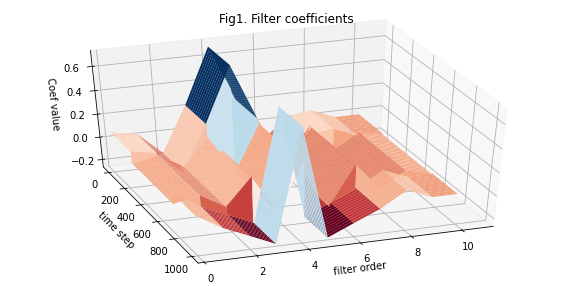

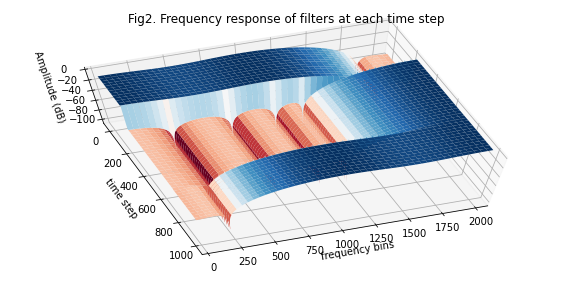

In [ ]:
# plot the filter and frequency response
# plot the filter coefficients (only (0, :, :))
plot_batch = 0

fig = plt.figure()
ax = fig.gca(projection='3d')
import importlib
importlib.reload(plot_lib)
plot_lib.plot_surface(tv_filter_coefs[plot_batch].numpy().T, fig, ax,
                      ylabel='time step', xlabel='filter order', zlabel='Coef value',
                      angleX=40, angleY=70)
ax.set_title("Fig1. Filter coefficients")
ax.set_xlim(tv_filter_coefs.shape[2], 0)

# plot the frequency response of filters for each time step (this may take some time)
# for simplicity, just plot the three sets of cofficients
def get_amp_(data):
    return 20*np.log10(np.abs(data) + np.finfo(np.float32).eps)

nfft=4096
w, h_lp_v = scipy.signal.freqz(lp_v, [1], worN=nfft, whole=True)
w, h_hp_v = scipy.signal.freqz(hp_v, [1], worN=nfft, whole=True)
w, h_hp_u = scipy.signal.freqz(hp_u, [1], worN=nfft, whole=True)
filter_res = np.zeros([tv_filter_coefs.shape[1], nfft//2+1])
filter_res[signal_length//4*0:signal_length//4*1, :] = get_amp_(h_lp_v[0:nfft//2+1])
filter_res[signal_length//4*1:signal_length//4*3, :] = get_amp_(h_hp_v[0:nfft//2+1])
filter_res[signal_length//4*3:, :] = get_amp_(h_hp_u[0:nfft//2+1])

fig = plt.figure()
ax = fig.gca(projection='3d')
plot_lib.plot_surface(filter_res.T, fig, ax,
                      ylabel='time step', xlabel='frequency bins', zlabel='Amplitude (dB)',
                      angleX=70, angleY=70)
ax.set_title("Fig2. Frequency response of filters at each time step")
ax.set_xlim(nfft//2+1, 0)

In [ ]:
# Do the filtering
tv_layer = TimeVariantFiltering()
signal_output = tv_layer(signal_input, tv_filter_coefs)

(2049.0, 0.0)

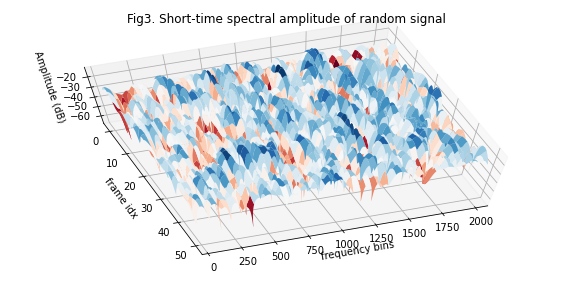

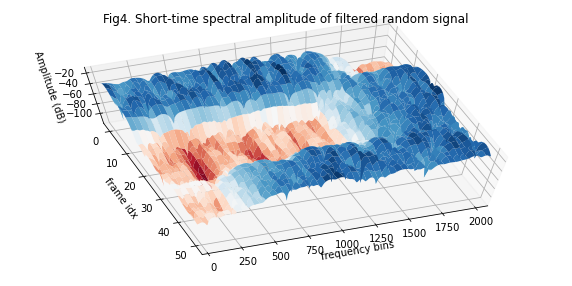

In [ ]:
# Plot
# let's try to plot the spectrogram
# let's analyze only one signal
import tool_lib
signal_in_examine = signal_input[0, :, 0]
signal_out_examine = signal_output[0, :, 0]

nfft=4096
spec_in_examine = tool_lib.spec_amplitude(signal_in_examine, frame_length=200, frame_shift=20, fft_bins=nfft)
spec_out_examine = tool_lib.spec_amplitude(signal_out_examine, frame_length=200, frame_shift=20, fft_bins=nfft)

fig = plt.figure()
ax = fig.gca(projection='3d')
plot_lib.plot_surface(spec_in_examine, fig, ax,
                      ylabel='frame idx', xlabel='frequency bins', zlabel='Amplitude (dB)',
                      angleX=70, angleY=70)
ax.set_title("Fig3. Short-time spectral amplitude of random signal")
ax.set_xlim(nfft//2+1, 0)

fig = plt.figure()
ax = fig.gca(projection='3d')
plot_lib.plot_surface(spec_out_examine, fig, ax,
                      ylabel='frame idx', xlabel='frequency bins', zlabel='Amplitude (dB)',
                      angleX=70, angleY=70)
ax.set_title("Fig4. Short-time spectral amplitude of filtered random signal")
ax.set_xlim(nfft//2+1, 0)

From the above figure, we can see how the spectral of the random noise is shaped by the time-variant filters.

This time-variant filter will be used in the next section for sinc-windowed

# Sec.4 Sinc-windowed Filter

## Sec.4.1 Explanation

When using a filter, we expect it to have a cut-off frequency at $f$ Hz.

If our API only supports filter coefficients as input, we need to do the additional step to derive the filter coefficients given the cut-off frequency $f$ Hz (i.e., filter design).

A convenient way is to use Sinc-windowed filter, which directly accepts cut-off frequency at $f$ Hz as input. It will automatically produce the filter coefficients. This makes life easier when we want to predict $f$ from other data.


Given a (normalized) cut-off frequency $w^{(c)}_{n}\in\mathbb{R}$, the sinc-windowed filter API returns a high-pass filter and a low-pass filter. Given a sequence of cut-off frequency $w^{(c)}_{1:N}$, it produces a sequence of filter coefficients.


## Sec.4.2 From Ideal Filter to Sinc-windowed Filter


The theory behind windowed sinc filter is well documented https://www.dspguide.com/ch16.htm. Here we briefly explain the idea.


### Sec.4.2.1 Ideal sinc filter

Suppose we need a low-pass filter with a cut-off frequency  of $f_c$ Hz.

The ideal shape of such a low-pass filter in the frequency domain should be a square window (right figure below). Its impulse response in the time domain is a sinc function $h(t) = \frac{sin(2\pi f_c t)}{\pi t}$ (left figure below).

In [ ]:
# wrapper functions for plotting
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams.update({'font.size': 12})

# define a wrapper for convenience
def plot_data(x_data, y_data, fig, axis, xlabel, ylabel, title):
    axis.plot(x_data, y_data, 'k')
    axis.grid(True)
    axis.set_xlabel(xlabel)
    axis.set_ylabel(ylabel)
    axis.set_title(title)
    return fig, axis

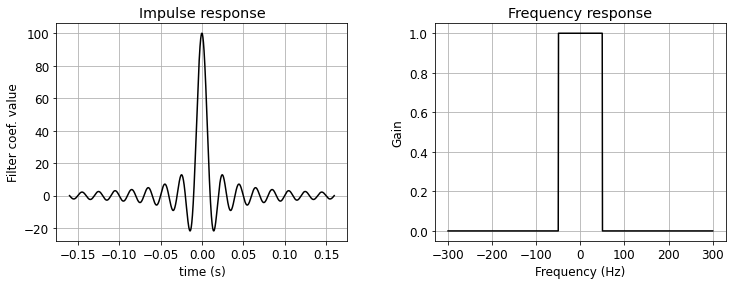

In [ ]:
# Note that we cannot plot the true h(t) and H(w) on digital computers
# Figures below are just approximation
import numpy as np

# F_c = 50Hz
f_c = 50

# freq domain
x_data = np.linspace(-300, 300, 1000)
y_data = np.zeros(x_data.shape)
y_data[np.bitwise_and(x_data>(-f_c), x_data<(f_c))] = 1.0
fig = plt.figure(figsize=(12, 4)); axis=fig.add_subplot(122);
plot_data(x_data, y_data, fig, axis, 'Frequency (Hz)', 'Gain', 'Frequency response')

# time domain
x_data_t = np.linspace(-0.16, 0.16, 10001)
y_data_t = 2 * f_c * np.sinc(2 * f_c * x_data_t)
axis = fig.add_subplot(121)
plot_data(x_data_t, y_data_t, fig, axis, 'time (s)', 'Filter coef. value', 'Impulse response')
fig.subplots_adjust(hspace=0, wspace=0.3)

### Sec.4.2.2 Ideal sinc filter in discrete-time domain

We cannot directly use the ideal impulse response of the low-pass filter because digital systems do not work in continuous-time domain. We have to use discrete-time versions.

Suppose we are sampling the ideal impulse response at $F_s=400 Hz$. The sampled impulse response can be written as

$h[n] = \frac{sin(2  \pi f_c \frac{n}{F_s})}{\pi n}= \frac{sin(\pi w_c n)}{\pi n}$.

Here we define $w_c = \frac{2f_c}{F_s} = \frac{f_c}{\frac{F_s}{2}}$ so that $w_c \in (0, 1)$ for $f_c\in(0, \frac{F_s}{2})$. This $w_c$ is known as the `Normalized Frequency` (see Alternative normalizations in [Wikipedia](https://en.wikipedia.org/wiki/Normalized_frequency_(unit))). This is convenient when we want to predict $w_c$ from neural networks.

The frequency and time domain of the discrete-time filter $h[n]$ will be:

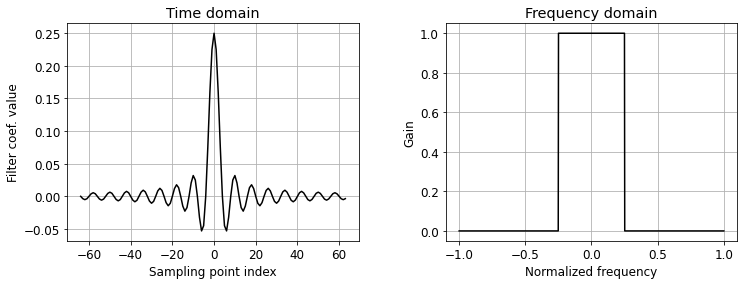

In [ ]:
# Discrete time Fourier transform
# Some useful online materials
# https://courses.engr.illinois.edu/ece401/sp2017/lecture13dtft.pdf
# https://courses.engr.illinois.edu/ece401/sp2017/lecture13dtft.pdf
# Note that w_c in this notebook refers to \frac{2f_c}/{F_s}, not w in above materials

# Frequency domain
f_s = 400
w_c = 2*f_c / f_s

fig = plt.figure(figsize=(12, 4)); axis=fig.add_subplot(122);
x_data = np.linspace(-1, 1, 1000)
y_data = np.zeros(x_data.shape)
y_data[np.bitwise_and(x_data>(-w_c), x_data<(w_c))] = 1.0
plot_data(x_data, y_data, fig, axis, 'Normalized frequency', 'Gain', 'Frequency domain')


# just plot part of the infinitely long filter
plot_range_inf = [-64, 64]
x_data_t = np.arange(plot_range_inf[0], plot_range_inf[1])
y_data_t = w_c * np.sinc(w_c * x_data_t)
axis = fig.add_subplot(121)
plot_data(x_data_t, y_data_t, fig, axis, 'Sampling point index', 'Filter coef. value', 'Time domain')
fig.subplots_adjust(hspace=0, wspace=0.3)

# The figure of `Frequency domain` plots frequency response for $w_c$ in the range $(-1, 1)$.
# Of course, $(-1, 0)$ is just mirror of (0, 1).
# Later, we only plot the positive range $w_c\in(0, 1)$.

### Sec.4.2.3 Practical Windowed Sinc Filter

However, it is still impossible to implement the discrete-time sinc filter because the discrete-time ideal filter is infinitely long, i.e., $n\in\{-\infty, \cdots, \infty\}$ (Although I plot the figures in 1.1 and 1.2, they are plotted only within a finite range for `plot_range_inf = [-64, 64]`.).

We need to truncate the impulse response, for example, by setting $h[n]=0$ for $n<-M$ and $n>M$. Then, we only store and use $h[n]$ for $n\in[-M, M]$.

However, such a simple truncating method leads to ripples in the passband (i.e., the [Gibbs effect](https://en.wikipedia.org/wiki/Gibbs_phenomenon)).

A better choice is to truncate the filter impulse response by multiplying it with a finite-length window function, such as [Hamming window](https://en.wikipedia.org/wiki/Window_function#Hann_and_Hamming_windows): $\text{Hamming}(n) = 0.54 + 0.46\cos(2\pi n / (2M+1)), n \in[-M, M]$.

The length of the truncated filter, or equivalently the length of the finite-length window $2M+1$, is referred to as the order of the windowed-sinc filter.

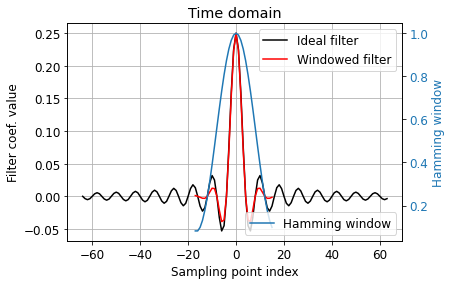

In [ ]:
fig = plt.figure(figsize=(12//2, 4)); axis=fig.add_subplot(111);

# just plot part of the infinitely long filter
x_data_t_inf = np.arange(plot_range_inf[0], plot_range_inf[1])
y_data_t_inf = w_c * np.sinc(w_c * x_data_t_inf)

# plot the truncated case
# let's use a filter of order 33
filter_order = 33

x_data_t = np.arange(-filter_order//2, filter_order//2)
# hamming window
y_hamming = 0.54 + 0.46 * np.cos(2 * np.pi * x_data_t / filter_order)
# truncated part not windowed
y_data_t = w_c * np.sinc(w_c * x_data_t)
# truncated and windowed
y_data_t_windowed = y_data_t * y_hamming

#
plot_data(x_data_t_inf, y_data_t_inf, fig, axis, 'Sampling point index', 'Filter coef. value', 'Time domain')
axis.plot(x_data_t, y_data_t_windowed, 'r')
axis.legend(['Ideal filter', 'Windowed filter'])

ax2 = axis.twinx()
color = 'tab:blue'
ax2.set_ylabel('Hamming window', color=color)
ax2.plot(x_data_t, y_hamming, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(['Hamming window'], loc=4)

Sometimes the windowed sinc filter may alter the signal energy. To make sure that the low-pass filter's gain is 1.0 at 0Hz, we can do a simple normalization:

${h}[n] \leftarrow \frac{{h}[n] \text{Hamming}(n)}{\sum_n {h}[n] \text{Hamming}(n)}$



For a high-pass filter, this is done by:

$\tilde{h}[n] = \frac{{h}[n] * \text{Hamming}(n)}{\sum_n (-1)^n {h}[n] \text{Hamming}(n)}$.


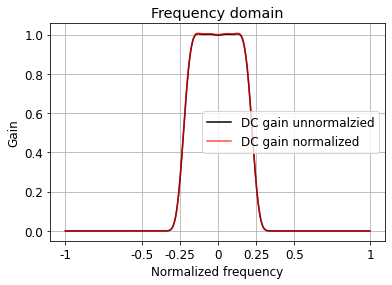

In [ ]:
import scipy
import scipy.signal

# Frequency response of the windowed sinc filter
# number of FFT points
fft_N=512

# calcualte frequency response, unnormalized
_, freq_res = scipy.signal.freqz(y_data_t_windowed, [1], worN=fft_N, whole=True)
# shift from [0, 2pi] to [-pi, pi] for plotting
freq_res = np.roll(freq_res, fft_N//2)

# normalized
y_data_t_windowed_normed = y_data_t_windowed / y_data_t_windowed.sum()
_, freq_res_normed = scipy.signal.freqz(y_data_t_windowed_normed, [1], worN=fft_N, whole=True)
freq_res_normed = np.roll(freq_res_normed, fft_N//2)


# plotting
fig = plt.figure(figsize=(12//2, 4)); axis=fig.add_subplot(111);
fig, axis = plot_data(np.arange(freq_res.shape[0]), np.power(np.abs(freq_res), 2), fig, axis,
                      'Normalized frequency', 'Gain', 'Frequency domain')
axis.plot(np.arange(freq_res_normed.shape[0]), np.power(np.abs(freq_res_normed), 2), 'r', alpha=0.7);

# plotting with labels
axis.set_xticks([0, fft_N//4, fft_N//8*3, fft_N//2, fft_N//8*5, fft_N//4*3, fft_N])
axis.set_xticklabels(["-1", '-0.5', '-0.25', '0', '0.25', '0.5', "1"])
axis.legend(['DC gain unnormalzied', 'DC gain normalized'])

# for this example, normalization is not necessary since y_data_t_windowed.sum() is alreay close to 1.0

Here are the wrappers:

In [ ]:
def return_winwdoed_sinc_low_pass(w_c, filter_order, norm=False):
    """ return_winwdoed_sinc_low_pass(w_c, filter_order, norm=False)
    Input:
        w_c: a real number, normalized cut-off frequency between (0, 1)
        filter_order: an odd integer number. The filter range will be [-filter_order//2, filter_order//2]
        norm: whether do gain normalization (default False)
    Output:
        y_data_t_windowed: low-pass filter coefficients
        y_hamming: hamming window coefficients
        x_data_t: time index for plotting figures
    """
    # x index
    x_data_t = np.arange(-filter_order//2, filter_order//2)
    # hamming window
    y_hamming = 0.54 + 0.46 * np.cos(2 * np.pi * x_data_t / x_data_t.shape[0])
    # truncated part not windowed
    y_data_t = w_c * np.sinc(w_c * x_data_t)
    # truncated and windowed
    y_data_t_windowed = y_data_t * y_hamming
    # normalize pass-band gain if necessary
    if norm:
        y_data_t_windowed = y_data_t_windowed/y_data_t_windowed.sum()

    # return filter coefficients, hamming window, and time step index
    return y_data_t_windowed, y_hamming, x_data_t

def return_winwdoed_sinc_high_pass(w_c, filter_order, norm=False):
    """ return_winwdoed_sinc_high_pass(w_c, filter_order, norm=False)
    Input:
        w_c: a real number, normalized cut-off frequency between (0, 1)
        filter_order: an odd integer number. The filter range will be [-filter_order//2, filter_order//2]
        norm: whether do gain normalization (default False)
    Output:
        y_data_t_windowed: high-pass filter coefficients
        y_hamming: hamming window coefficients
        x_data_t: time index for plotting figures
    """
    # x index
    x_data_t = np.arange(-filter_order//2, filter_order//2)
    # hamming window
    y_hamming = 0.54 + 0.46 * np.cos(2 * np.pi * x_data_t / x_data_t.shape[0])
    # truncated part not windowed
    y_data_t = np.sinc(1.0 * x_data_t) - w_c * np.sinc(w_c * x_data_t)
    # truncated and windowed
    y_data_t_windowed = y_data_t * y_hamming

    # normalize pass-band gain if necessary
    if norm:
        minus_one = np.power(-1, np.abs(x_data_t))
        y_data_t_windowed = y_data_t_windowed/(y_data_t_windowed*minus_one).sum()
    # return filter coefficients, hamming window, and time step index
    return y_data_t_windowed, y_hamming, x_data_t


In [ ]:
# A wrapper for visualization


def plot_windowed_case(w_c, filter_order, plot_range_inf=[-64, 64],
                       low_pass=True, only_window_filter=False, half_freq=False,
                       grid_on=True):
    """ A wrapper to plot the filters in frequency and time domain
    w_c: cut-off frequency, a real-number between (0, 1)
    filter_order: filter order, an integer number
    plot_range_inf: [-P, P], this is used to set the x-range for plotting ideal filter
    """
    # wrapper to plot figures
    def plot_data(x_data, y_data, fig, axis, xlabel, ylabel, title, grid_on):
        axis.plot(x_data, y_data, 'k')
        axis.grid(grid_on)
        axis.set_xlabel(xlabel)
        axis.set_ylabel(ylabel)
        axis.set_title(title)

    fig = plt.figure(figsize=(12, 4));

    axis=fig.add_subplot(121);
    # just plot part of the infinitely long filter
    x_data_t_inf = np.arange(plot_range_inf[0], plot_range_inf[1])
    if low_pass:
        y_data_t_inf = w_c * np.sinc(w_c * x_data_t_inf)
    else:
        y_data_t_inf = np.sinc(x_data_t_inf) - w_c * np.sinc(w_c * x_data_t_inf)

    if not only_window_filter:
        plot_data(x_data_t_inf, y_data_t_inf, fig, axis, 'Sampling point index', 'Filter coef. value', 'Time domain', grid_on)
        axis.set_xlim(plot_range_inf)

    # get and plot the truncated case
    if low_pass:
        y_data_t_windowed, y_hamming, x_data_t = return_winwdoed_sinc_low_pass(w_c, filter_order, True)
    else:
        y_data_t_windowed, y_hamming, x_data_t = return_winwdoed_sinc_high_pass(w_c, filter_order, True)
    if not only_window_filter:
        axis.plot(x_data_t, y_data_t_windowed, 'r')
        axis.legend(['Ideal filter', 'Windowed filter'])
    else:
        plot_data(x_data_t, y_data_t_windowed, fig, axis, 'Sampling point index', 'Filter coef. value', 'Time domain', grid_on)

    # plot the hamming window
    if not only_window_filter:
        ax2 = axis.twinx()
        ax2.set_ylabel('Hamming window', color='tab:blue')
        ax2.plot(x_data_t, y_hamming, color='tab:blue')
        ax2.tick_params(axis='y', labelcolor='tab:blue')
        ax2.legend(['Hamming window'], loc=4)

    # plot frequency response
    axis=fig.add_subplot(122);

    fft_N=512
    _, freq_res = scipy.signal.freqz(y_data_t_windowed, [1], worN=fft_N, whole=True)
    # shift from [0, 2pi] to [-pi, pi] for plotting
    if not half_freq:
        freq_res = np.roll(freq_res, fft_N//2)
        plot_data(np.arange(freq_res.shape[0]), np.abs(freq_res), fig, axis, 'Normalized frequency', 'Gain', 'Frequency domain', grid_on)
        axis.set_xticks([int(fft_N * x) for x in [0, 1/8, 1/4, 3/8, 1/2, 5/8, 3/4, 7/8, 1]])
        axis.set_xticklabels(["-1", '-0.75', '-0.5', '-0.25', '0', '0.25', '0.5', '0.75', "1"])
    else:
        plot_data(np.arange(fft_N//2+1), np.abs(freq_res[0:fft_N//2+1]), fig, axis, 'Normalized frequency', 'Gain', 'Frequency domain', grid_on)
        axis.set_xticks([0, fft_N//8, fft_N//4, fft_N//8*3, fft_N//2])
        axis.set_xticklabels(['0', '0.25', '0.5', '0.75', "1"])
    if low_pass:
        fig.text(0.5, 0.98, "w_c: %0.2f, order: %d, loss-pass" % (w_c, filter_order), horizontalalignment='center')
    else:
        fig.text(0.5, 0.98, "w_c: %0.2f, order: %d, high-pass" % (w_c, filter_order), horizontalalignment='center')
    fig.subplots_adjust(hspace=0, wspace=0.3)
    return

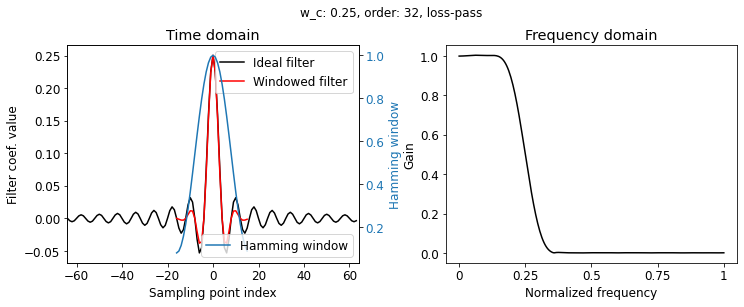

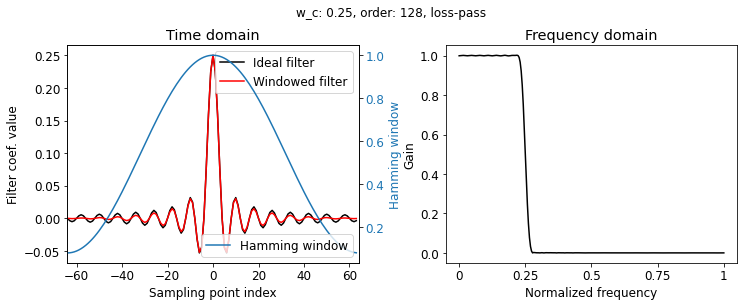

In [ ]:
# plot a few cases with different filter order
plot_windowed_case(w_c, filter_order=32,  low_pass=True, half_freq=True, grid_on=False)
plot_windowed_case(w_c, filter_order=128, low_pass=True, half_freq=True, grid_on=False)
#plot_windowed_case(w_c, filter_order=32,  low_pass=False)
#plot_windowed_case(w_c, filter_order=128, low_pass=False)

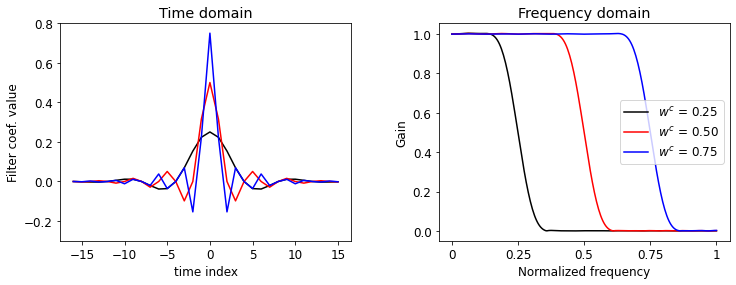

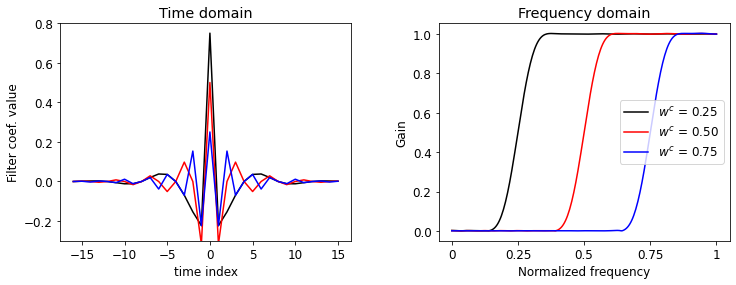

In [ ]:
# This is another wrapper for figure plotting.

def plot_windowed_case2(w_c_list, legends, filter_order, plot_range_inf=[-64, 64], low_pass=True, grid_on=True):
    color_bags = ['k', 'r', 'b', 'g']
    if len(w_c_list) > len(color_bags):
        print("Not enough colors")
        return

    # wrapper to plot figures
    def plot_data(x_data, y_data, fig, axis, xlabel, ylabel, title, grid_on, color):
        axis.plot(x_data, y_data, color)
        axis.grid(grid_on)
        axis.set_xlabel(xlabel)
        axis.set_ylabel(ylabel)
        axis.set_title(title)

    fig = plt.figure(figsize=(12, 4));

    # get and plot the truncated case
    axis=fig.add_subplot(121);
    for w_c, color in zip(w_c_list, color_bags):
        if low_pass:
            y_data_t_windowed, y_hamming, x_data_t = return_winwdoed_sinc_low_pass(w_c, filter_order, True)
        else:
            y_data_t_windowed, y_hamming, x_data_t = return_winwdoed_sinc_high_pass(w_c, filter_order, True)
        plot_data(x_data_t, y_data_t_windowed, fig, axis, 'time index', 'Filter coef. value', 'Time domain', grid_on, color)
        axis.set_ylim(-0.3, 0.8)

    axis=fig.add_subplot(122);
    for w_c, color in zip(w_c_list, color_bags):
        if low_pass:
            y_data_t_windowed, y_hamming, x_data_t = return_winwdoed_sinc_low_pass(w_c, filter_order, True)
        else:
            y_data_t_windowed, y_hamming, x_data_t = return_winwdoed_sinc_high_pass(w_c, filter_order, True)

        # plot frequency response
        fft_N=512
        _, freq_res = scipy.signal.freqz(y_data_t_windowed, [1], worN=fft_N, whole=True)
        # shift from [0, 2pi] to [-pi, pi] for plotting
        plot_data(np.arange(fft_N//2+1), np.abs(freq_res[0:fft_N//2+1]), fig, axis, 'Normalized frequency', 'Gain', 'Frequency domain', grid_on, color)
        axis.set_xticks([0, fft_N//8, fft_N//4, fft_N//8*3, fft_N//2])
        axis.set_xticklabels(['0', '0.25', '0.5', '0.75', "1"])
    axis.legend(legends);
    fig.subplots_adjust(hspace=0, wspace=0.3)
    return


plot_windowed_case2([0.25, 0.5, 0.75], ["$w^c$ = 0.25", "$w^c$ = 0.50", "$w^c$ = 0.75"],filter_order=32, low_pass=True, grid_on=False)
plot_windowed_case2([0.25, 0.5, 0.75], ["$w^c$ = 0.25", "$w^c$ = 0.50", "$w^c$ = 0.75"],filter_order=32, low_pass=False, grid_on=False)

#for w_c in [0.25, 0.5, 0.75]:
#    plot_windowed_case2([w_c], ["$w^c$ = %0.2f" % (w_c)], filter_order=32, low_pass=True, grid_on=False)
#    plot_windowed_case2([w_c], ["$w^c$ = %0.2f" % (w_c)], filter_order=32, low_pass=False, grid_on=False

## Sec.4.3 Pytorch Module Definition

Based on the discussion above, we can define the Pytorch Module.

1. Input $w_{1:N}^{(c)}$ as tensor of shape `(batchsize, length=N, 1)`
2. Hyper-parameter $K$ defines the order of filter
3. Output low-pass filter coefficients is a tensor `(batchsize, length, filter_order=K)`
4. Output high-pass filter coefficients is a tensor `(batchsize, length, filter_order)`
5. $w_n^{(c)}\in(0, 1)$

Note that we are defining time-variant filters. We will have one filter for each time step $n\in\{1,\cdots, N\}$.


The wrapper does operations shown in the figure below:



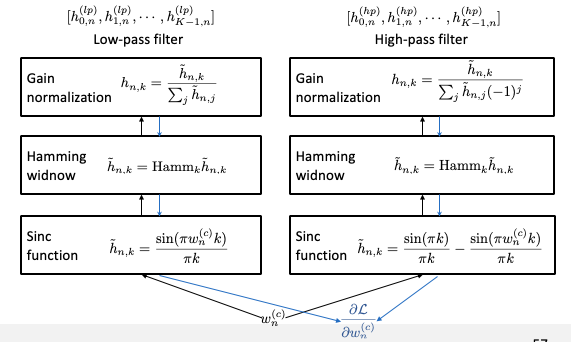

In [ ]:
Image("/content/figures/fig_c8_1.png")



The above process is differentiable. Once we know the gradients w.r.t filter coefficients, we can back-propagate the gradients and get the gradients w.r.t $w_c$ (shown in blue arrows).

The above figure shows the procedure to produce one filter pair for one $w_c$.
In practice, the input may be a sequence $\{w_{1}^{(c)}, w_{2}^{(c)}, \cdots, w_{N}^{(c)}\}$. We will generate a sequence of high and low-pass filter coefficients $\{\{\boldsymbol{h}_{1}^{(hp)}, \boldsymbol{h}_{1}^{(lp)}\}, \{\boldsymbol{h}_{2}^{(hp)}, \boldsymbol{h}_{2}^{(lp)}\}, \cdots, \{\boldsymbol{h}_{N}^{(hp)}, \boldsymbol{h}_{N}^{(lp)}\}\}$, where $\boldsymbol{h}_{n}^{(lp)}=[{h}_{0, n}^{(lp)}, {h}_{1, n}^{(lp)}, \cdots, {h}_{K-1, n}^{(lp)}]$ and $\boldsymbol{h}_{n}^{(hp)}=[{h}_{0, n}^{(hp)}, {h}_{1, n}^{(hp)}, \cdots, {h}_{K-1, n}^{(hp)}]$

In [ ]:
import torch
import torch.nn as torch_nn
import torch.nn.functional as torch_nn_func
import sys

# Sinc filter generator
class SincFilter(torch_nn.Module):
    """ SincFilter
        Given the cut-off-frequency, produce the low-pass and high-pass
        windowed-sinc-filters.
        If input cut-off-frequency is (batchsize, signal_length, 1),
        output filter coef is (batchsize, signal_length, filter_order).

        For each time step in [1, signal_length), we calculate one
        filter for low-pass sinc filter and another for high-pass filter.

        Example:
        import scipy
        import scipy.signal
        import numpy as np

        filter_order = 31
        cut_f = 0.2
        sinc_layer = SincFilter(filter_order)
        lp_coef, hp_coef = sinc_layer(torch.ones(1, 10, 1) * cut_f)

        w, h1 = scipy.signal.freqz(lp_coef[0, 0, :].numpy(), [1])
        w, h2 = scipy.signal.freqz(hp_coef[0, 0, :].numpy(), [1])
        plt.plot(w, 20*np.log10(np.abs(h1)))
        plt.plot(w, 20*np.log10(np.abs(h2)))
        plt.plot([cut_f * np.pi, cut_f * np.pi], [-100, 0])
    """
    def __init__(self, filter_order):
        super(SincFilter, self).__init__()
        # Make the filter oder an odd number
        #  [-(M-1)/2, ... 0, (M-1)/2]
        #
        self.half_k = (filter_order - 1) // 2
        self.order = self.half_k * 2 +1

    def hamming_w(self, n_index):
        """ prepare hamming window for each time step
        n_index (batchsize=1, signal_length, filter_order)
            For each time step, n_index will be [-(M-1)/2, ... 0, (M-1)/2]
            n_index[0, 0, :] = [-(M-1)/2, ... 0, (M-1)/2]
            n_index[0, 1, :] = [-(M-1)/2, ... 0, (M-1)/2]
            ...
        output  (batchsize=1, signal_length, filter_order)
            output[0, 0, :] = hamming_window
            output[0, 1, :] = hamming_window
            ...
        """
        # Hamming window
        return 0.54 + 0.46 * torch.cos(2 * np.pi * n_index / self.order)

    def sinc(self, x):
        """ Normalized sinc-filter sin( pi * x) / pi * x
        https://en.wikipedia.org/wiki/Sinc_function

        Assume x (batchsize, signal_length, filter_order) and
        x[0, 0, :] = [-half_order, - half_order+1, ... 0, ..., half_order]
        x[:, :, self.half_order] -> time index = 0, sinc(0)=1
        """
        y = torch.zeros_like(x)
        y[:,:,0:self.half_k]=torch.sin(np.pi * x[:, :, 0:self.half_k]) \
                                / (np.pi * x[:, :, 0:self.half_k])
        y[:,:,self.half_k+1:]=torch.sin(np.pi * x[:, :, self.half_k+1:]) \
                                / (np.pi * x[:, :, self.half_k+1:])
        y[:,:,self.half_k] = 1
        return y

    def forward(self, cut_f):
        """ lp_coef, hp_coef = forward(self, cut_f)
        cut-off frequency cut_f (batchsize=1, length, dim = 1)

        lp_coef: low-pass filter coefs  (batchsize, length, filter_order)
        hp_coef: high-pass filter coefs (batchsize, length, filter_order)
        """
        # create the filter order index
        with torch.no_grad():
            # [- (M-1) / 2, ..., 0, ..., (M-1)/2]
            lp_coef = torch.arange(-self.half_k, self.half_k + 1,
                                   device=cut_f.device)
            # [[[- (M-1) / 2, ..., 0, ..., (M-1)/2],
            #   [- (M-1) / 2, ..., 0, ..., (M-1)/2],
            #   ...
            #  ],
            #  [[- (M-1) / 2, ..., 0, ..., (M-1)/2],
            #   [- (M-1) / 2, ..., 0, ..., (M-1)/2],
            #   ...
            #  ]]
            lp_coef = lp_coef.repeat(cut_f.shape[0], cut_f.shape[1], 1)

            hp_coef = torch.arange(-self.half_k, self.half_k + 1,
                                   device=cut_f.device)
            hp_coef = hp_coef.repeat(cut_f.shape[0], cut_f.shape[1], 1)

            # temporary buffer of [-1^n] for gain norm in hp_coef
            tmp_one = torch.pow(-1, hp_coef)

        # unnormalized filter coefs with hamming window
        lp_coef = cut_f * self.sinc(cut_f * lp_coef) \
                  * self.hamming_w(lp_coef)
        hp_coef = (self.sinc(hp_coef)-cut_f * self.sinc(cut_f * hp_coef))\
                  * self.hamming_w(hp_coef)

        # normalize the coef to make gain at 0/pi is 0 dB
        # sum_n lp_coef[n]
        lp_coef_norm = torch.sum(lp_coef, axis=2).unsqueeze(-1)
        # sum_n hp_coef[n] * -1^n
        hp_coef_norm = torch.sum(hp_coef * tmp_one, axis=2).unsqueeze(-1)

        lp_coef = lp_coef / lp_coef_norm
        hp_coef = hp_coef / hp_coef_norm

        # return normed coef
        return lp_coef, hp_coef

## Sec.4.4 Example Usage

In [ ]:
# configuration

# consider a simple example of generating filters for 4 time steps
signal_length = 4
# cut-off-frequency for 1st signal in the batch
sinc_cut_off_1 = 0.4
# cut-off-frequency for 2nd signal in the batch
sinc_cut_off_2 = 0.6

# use constant w_c
sinc_cut_off_freq = torch.ones(2, signal_length, 1) * sinc_cut_off_1
sinc_cut_off_freq[1, :, :] = torch.ones(signal_length, 1) * sinc_cut_off_2

# order of the sinc filters
sinc_filter_order = 31

print("Input w_c has shape", str(sinc_cut_off_freq.shape))
print("Batch = ", str(sinc_cut_off_freq.shape[0]))
print("Number of time steps = ", str(sinc_cut_off_freq.shape[1]))

Input w_c has shape torch.Size([2, 4, 1])
Batch =  2
Number of time steps =  4


The low-pass filter coef tensor has shape torch.Size([2, 4, 31])
The high-pass filter coef tensor has shape torch.Size([2, 4, 31])


(<Figure size 1130.4x158.4 with 2 Axes>,
  <matplotlib.axes._axes.Axes at 0x7feae4b6ef90>])

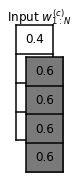

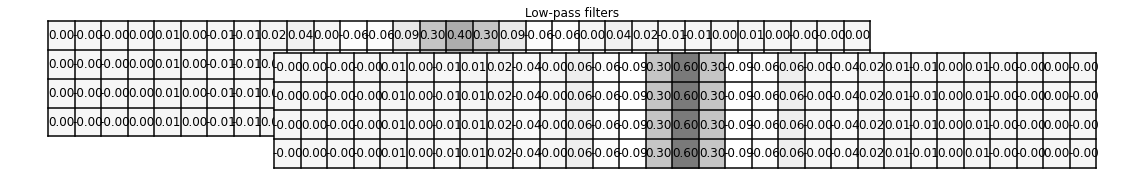

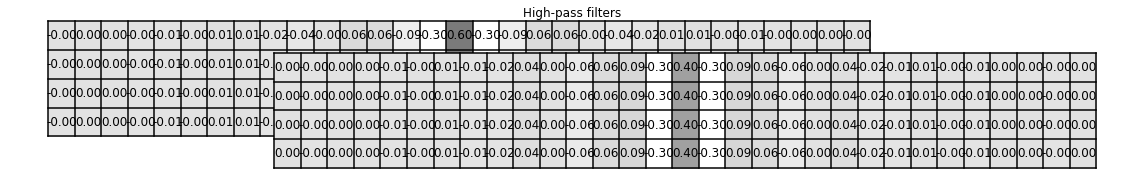

In [ ]:
# initialzie the layer
sinc_layer = SincFilter(sinc_filter_order)

# get the pair of high- and low-pass filter coefficients
with torch.no_grad():
  lp_coef, hp_coef = sinc_layer(sinc_cut_off_freq)

print("The low-pass filter coef tensor has shape", str(lp_coef.shape))
print("The high-pass filter coef tensor has shape", str(hp_coef.shape))

import plot_lib
plot_lib.plot_tensor(sinc_cut_off_freq, color_on_value=True, shift=0.2, title='Input $w_{1:N}^{(c)}$')
plot_lib.plot_tensor(lp_coef, color_on_value=True, shift=0.2, deci_width=2, title='Low-pass filters')
plot_lib.plot_tensor(hp_coef, color_on_value=True, shift=0.2, deci_width=2, title='High-pass filters')

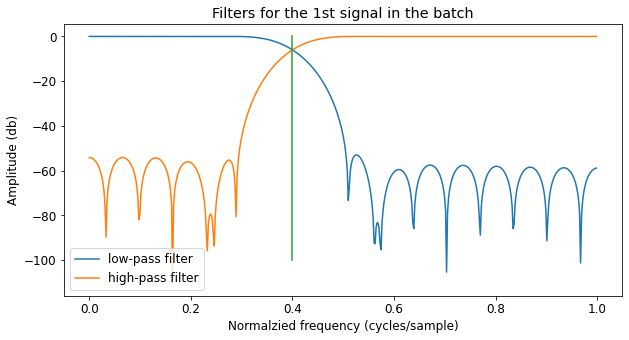

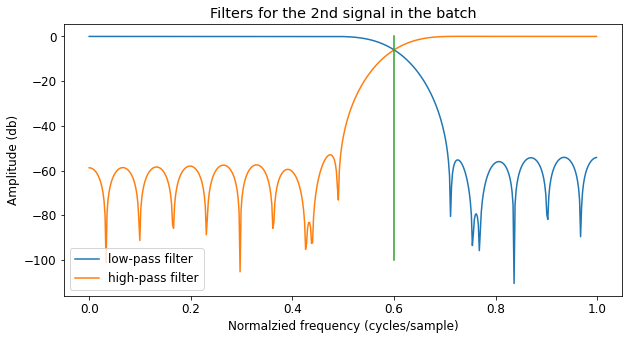

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (10, 5)


import scipy
import scipy.signal

# which time step to check?
# Just plot the first time step
time_step = 0

# frequency response of the filters for the first signal, at time step 0
w, h1 = scipy.signal.freqz(lp_coef[0, time_step, :].numpy(), [1])
w, h2 = scipy.signal.freqz(hp_coef[0, time_step, :].numpy(), [1])
plt.figure()
plt.plot(w/np.pi, 20*np.log10(np.abs(h1)))
plt.plot(w/np.pi, 20*np.log10(np.abs(h2)))
plt.plot([sinc_cut_off_1, sinc_cut_off_1], [-100, 0])
plt.ylabel('Amplitude (db)')
plt.xlabel('Normalzied frequency (cycles/sample)')
plt.title("Filters for the 1st signal in the batch")
plt.legend(["low-pass filter", "high-pass filter"])
# frequency response of the filters in the first batch

# frequency response of the filters for the second signal, at time step 0
plt.figure()
w, h1 = scipy.signal.freqz(lp_coef[1, time_step, :].numpy(), [1])
w, h2 = scipy.signal.freqz(hp_coef[1, time_step, :].numpy(), [1])
plt.plot(w / np.pi, 20*np.log10(np.abs(h1)))
plt.plot(w / np.pi, 20*np.log10(np.abs(h2)))
plt.plot([sinc_cut_off_2 , sinc_cut_off_2], [-100, 0])
plt.ylabel('Amplitude (db)')
plt.xlabel('Normalzied frequency (cycles/sample)')
plt.title("Filters for the 2nd signal in the batch")
plt.legend(["low-pass filter", "high-pass filter"])


## Sec.4.5 A More complicated Example

Let's use the sinc-windowed filters with the time-variant filtering API.


### Sec.4.5.1 Prepare the filters

In [ ]:
# generate the low-pass and high-pass filters
#
signal_length = 4000

# let's create a time variant sinc filter
sinc_cut_off_1 = 0.4
sinc_cut_off_2 = 0.6
sinc_cut_off_freq = torch.ones(1, signal_length, 1)

# first 1/4 part uses w_c = 0.4
# middle 1/2 part uses w_c = 0.6
# last 1/4 part uses w_c = 0.4
sinc_cut_off_freq[0, 0:signal_length//4, :] = sinc_cut_off_1
sinc_cut_off_freq[0, signal_length//4:signal_length*3//4, :] = sinc_cut_off_2
sinc_cut_off_freq[0, signal_length*3//4:, :] = sinc_cut_off_1

# initialzie the layer
sinc_filter_order = 31
sinc_layer = SincFilter(sinc_filter_order)

# get the pair of high- and low-pass filter coefficients
with torch.no_grad():
  lp_coef, hp_coef = sinc_layer(sinc_cut_off_freq)

(2049.0, 0.0)

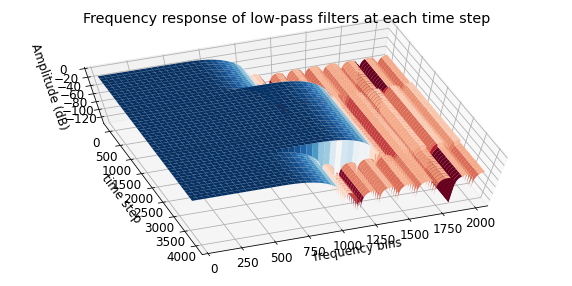

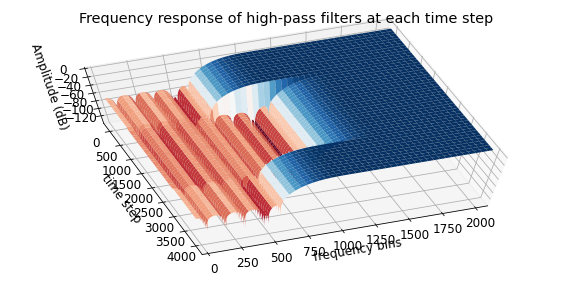

In [ ]:
# plot the frequency response of filters for each time step (this may take some time)
def get_fft_amp_(data, nfft):
    w, fres = scipy.signal.freqz(data, [1], worN=nfft, whole=True)
    return 20*np.log10(np.abs(fres[0:nfft//2+1]) + np.finfo(np.float32).eps)

nfft=int(np.power(2, np.ceil(np.log2(signal_length))))

# for simplicity, just calculate the frequency response for a few time steps and
# duplicate it to other time steps
lp_filter_res = np.zeros([lp_coef.shape[1], nfft//2+1])
# first 1/4 part uses w_c = 0.4
lp_filter_res[0:signal_length//4, :] = get_fft_amp_(lp_coef[0, 0, :], nfft)
# middle 1/2 part uses w_c = 0.6
lp_filter_res[signal_length//4:signal_length*3//4, :] = get_fft_amp_(lp_coef[0, signal_length//4, :], nfft)
# last 1/4 part uses w_c = 0.4
lp_filter_res[signal_length*3//4:, :] = get_fft_amp_(lp_coef[0, signal_length*3//4, :], nfft)

hp_filter_res = np.zeros([hp_coef.shape[1], nfft//2+1])
hp_filter_res[0:signal_length//4, :] = get_fft_amp_(hp_coef[0, 0, :], nfft)
hp_filter_res[signal_length//4:signal_length*3//4, :] = get_fft_amp_(hp_coef[0, signal_length//4, :], nfft)
hp_filter_res[signal_length*3//4:, :] = get_fft_amp_(hp_coef[0, signal_length*3//4, :], nfft)


fig = plt.figure()
ax = fig.gca(projection='3d')
plot_lib.plot_surface(lp_filter_res.T, fig, ax,
                      ylabel='time step', xlabel='frequency bins', zlabel='Amplitude (dB)',
                      angleX=70, angleY=70)
ax.set_title("Frequency response of low-pass filters at each time step")
ax.set_xlim(nfft//2+1, 0)

fig = plt.figure()
ax = fig.gca(projection='3d')
plot_lib.plot_surface(hp_filter_res.T, fig, ax,
                      ylabel='time step', xlabel='frequency bins', zlabel='Amplitude (dB)',
                      angleX=70, angleY=70)
ax.set_title("Frequency response of high-pass filters at each time step")
ax.set_xlim(nfft//2+1, 0)

### Sec.4.5.2 Filtering using Time-Variant Filtering API

In [ ]:
# Generate the signals and make sure that the amplitude of signal is around 0 dB
signal_input_raw = torch.randn(1, signal_length, 1)
signal_input = signal_input_raw
signal_input[0, :, :] = signal_input_raw[0, :, :] / np.abs(scipy.fft.fft(signal_input_raw[0, :, 0].detach().numpy(), n=nfft)).mean()

# Do filtering
tv_layer = TimeVariantFiltering()

signal_input.requires_grad=False
with torch.no_grad():
    data_lp = tv_layer(signal_input, lp_coef)
    data_hp = tv_layer(signal_input, hp_coef)

(2049.0, 0.0)

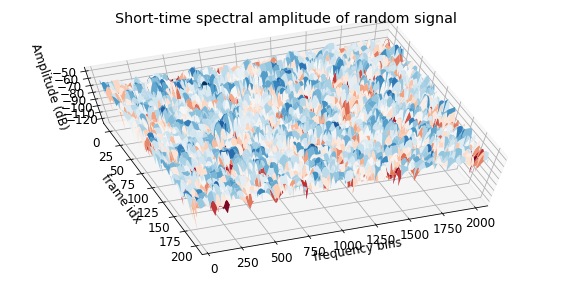

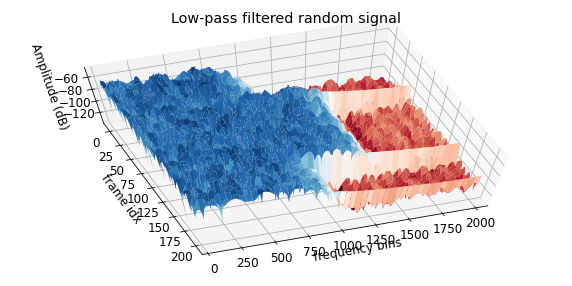

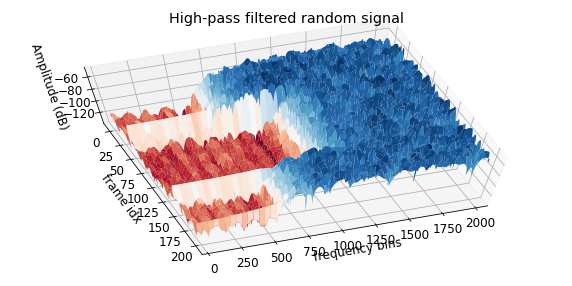

In [ ]:
# Plot
# let's try to plot the spectrogram
import tool_lib
signal_in_examine = signal_input[0, :, 0]
signal_out_lp = data_lp[0, :, 0]
signal_out_hp = data_hp[0, :, 0]

nfft=int(np.power(2, np.ceil(np.log2(signal_length))))
spec_in_examine = tool_lib.spec_amplitude(signal_in_examine, frame_length=200, frame_shift=20, fft_bins=nfft)
spec_out_lp = tool_lib.spec_amplitude(signal_out_lp, frame_length=200, frame_shift=20, fft_bins=nfft)
spec_out_hp = tool_lib.spec_amplitude(signal_out_hp, frame_length=200, frame_shift=20, fft_bins=nfft)

fig = plt.figure()
ax = fig.gca(projection='3d')
plot_lib.plot_surface(spec_in_examine, fig, ax,
                      ylabel='frame idx', xlabel='frequency bins', zlabel='Amplitude (dB)',
                      angleX=70, angleY=70)
ax.set_title("Short-time spectral amplitude of random signal")
ax.set_xlim(nfft//2+1, 0)

fig = plt.figure()
ax = fig.gca(projection='3d')
plot_lib.plot_surface(spec_out_lp, fig, ax,
                      ylabel='frame idx', xlabel='frequency bins', zlabel='Amplitude (dB)',
                      angleX=70, angleY=70)
ax.set_title("Low-pass filtered random signal")
ax.set_xlim(nfft//2+1, 0)

fig = plt.figure()
ax = fig.gca(projection='3d')
plot_lib.plot_surface(spec_out_hp, fig, ax,
                      ylabel='frame idx', xlabel='frequency bins', zlabel='Amplitude (dB)',
                      angleX=70, angleY=70)
ax.set_title("High-pass filtered random signal")
ax.set_xlim(nfft//2+1, 0)

# License
```
BSD 3-Clause License

Copyright (c) 2022, Xin Wang, National Institute of Informatics
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
```

# ACKNOWLEDGEMENT
This work is partially supported by JST CREST Grants (JPMJCR18A6 and JPMJCR20D3), MEXT KAKENHI Grants (21K17775, 21H04906).